<a href="https://colab.research.google.com/github/aimllearning/CapstoneProject/blob/master/CapstoneProject_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Capstone Project Computer Vision**

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

#install pydicom
!pip install pydicom
#import pydicom
import pydicom


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Set Image Extraction Path

import os
#%cd '../../'
%cd 'drive/My Drive/Colab Notebooks'

/content/drive/My Drive/Colab Notebooks


In [0]:
#extract the data
#%cd 'drive/My Drive/Colab Notebooks/Data/DCM'
from zipfile import ZipFile
testImagesPath = 'Data/stage_2_test_images.zip'
trainImagesPath = 'Data/stage_2_train_images.zip'
#extract test images
with ZipFile(testImagesPath, 'r') as z:
  z.extractall('Data/DCM_Test_Images/')
#extract train images
with ZipFile(trainImagesPath, 'r') as z:
   z.extractall('Data/DCM_Train_Images/')

In [6]:
#do listing of the data which we are using for input
print(os.listdir("Data"))

['stage_2_detailed_class_info (1).csv', 'stage_2_detailed_class_info.csv', 'stage_2_train_labels.csv', 'stage_2_train_labels.csv.zip', 'stage_2_sample_submission.csv', 'GCP Credits Request Link - RSNA.txt', 'stage_2_test_images.zip', 'stage_2_train_images.zip', 'DCM']


Let's explore the target classes

In [7]:
patient_classes = pd.read_csv('Data/stage_2_detailed_class_info.csv')
patient_classes.head(10)

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
5,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
6,00569f44-917d-4c86-a842-81832af98c30,No Lung Opacity / Not Normal
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,No Lung Opacity / Not Normal
8,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity
9,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity


Number of total target classes and their names

In [8]:
print("Number of classes in the dataset :: %i" %  len(patient_classes["class"].unique()))
print("Classes' names are :: %s" % patient_classes["class"].unique())

Number of classes in the dataset :: 3
Classes' names are :: ['No Lung Opacity / Not Normal' 'Normal' 'Lung Opacity']


Checking the skewness of the data in each data class

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64


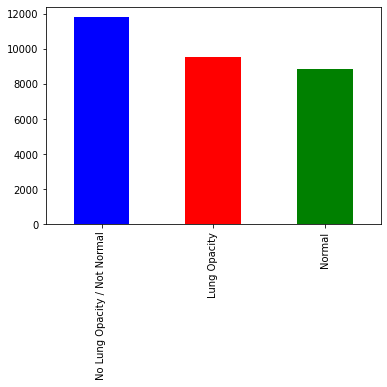

In [9]:
class_count = patient_classes['class'].value_counts()
class_count.plot(kind='bar',color= list('brg'))
print(class_count)

From above we observe that the data is not skewed. Let's proceed with the further

Now let's have a look on our train_labels data

In [10]:
train_labels = pd.read_csv('Data/stage_2_train_labels.csv')
print(train_labels.iloc[0])

patientId    0004cfab-14fd-4e49-80ba-63a80b6bddd6
x                                             NaN
y                                             NaN
width                                         NaN
height                                        NaN
Target                                          0
Name: 0, dtype: object


From the above example we see that for every label we have a patient ID, and bounding boxes coordinates which are nulls for class 0 and have values for class 1

We can proceed to explore the images and their meta data informaion. Tne images are stored in DICOM format which stores the meta data about each image in the dataset. 

We can explore the meta data information stored for images.

In [12]:
dcm_file = 'Data/DCM_Train_Images/%s.dcm' % train_labels.patientId.tolist()[0]
dcm_data = pydicom.read_file(dcm_file)
print(dcm_data) 

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0020) Patient ID                          LO: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient'

we can store all distinct IDs in the dataframe for later use

In [0]:
patientIds = train_labels.drop_duplicates('patientId', keep = 'first').patientId.tolist()

We can extract some of the attributes from the meta data available for each images and store it in dataframes to use later

In [0]:
Sex = []
Age = []
for patientId in patientIds:
    dcm_file = 'Data/DCM_Train_Images/%s.dcm' % patientId
    dcm_data = pydicom.read_file(dcm_file)
    Sex.append(dcm_data.PatientSex)
    Age.append(int(dcm_data.PatientAge))

In [15]:
patientInfo = pd.DataFrame({'patientId': patientIds, 'patientSex': Sex, 'patientAge': Age})
patientInfo.dtypes

patientId     object
patientSex    object
patientAge     int64
dtype: object

We can look for missing values in the dataframes that we have extracted

In [16]:
patientAge_count = patientInfo['patientAge'].value_counts().sum()
patientSex_count = patientInfo['patientSex'].value_counts().sum()
patient_count = patientInfo['patientId'].value_counts().sum()

print("total number of patientId :: %i" % patient_count )
print("Total number of patients with Non null patientSex :: %i " % patientSex_count )
print("Total number of patients with Non null patientAge :: %i " %  patientAge_count )
print("Number of missing values to be imputed for the first field :: %i " % (patient_count - patientSex_count) )
print("Number of missing values to be imputed for the second field :: %i " % (patient_count - patientAge_count) )

total number of patientId :: 26684
Total number of patients with Non null patientSex :: 26684 
Total number of patients with Non null patientAge :: 26684 
Number of missing values to be imputed for the first field :: 0 
Number of missing values to be imputed for the second field :: 0 


In [17]:
patientInfo = patientInfo.set_index('patientId').join(train_labels.set_index('patientId'))[['patientSex', 'patientAge', 'Target']]
patientInfo.reset_index(inplace=True)
patientInfo.head()

,patientId,patientSex,patientAge,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,F,51,0
1,000924cf-0f8d-42bd-9158-1af53881a557,F,19,0
2,000db696-cf54-4385-b10b-6b16fbb3f985,F,25,1
3,000db696-cf54-4385-b10b-6b16fbb3f985,F,25,1
4,000fe35a-2649-43d4-b027-e67796d412e0,M,40,1


In [18]:
patientInfo.describe()

,patientAge,Target
count,30227.000000,30227.000000
mean,46.797764,0.316108
std,16.892940,0.464963
min,1.000000,0.000000
25%,34.000000,0.000000
50%,49.000000,0.000000
75%,59.000000,1.000000
max,155.000000,1.000000


Exploring different attributes from datafrmaes formed out of meta data

In [19]:
#Eploring Age attribute

patientInfo['patientAge'].unique()

array([ 51,  19,  25,  40,  57,  56,  76,  31,  54,  28,  63,  48,  32,
        26,  22,  12,  78,  75,  23,  59,  49,   6,  70,  58,  36,  73,
        43,  60,  21,  72,  52,  55,  53,  16,  71,  77,  50,  39,  69,
        38,  47,  67,  44,  14,  68,  42,  41,  62,  15,  29,   2,  13,
        34,  61,  35,  66,  45,  74,  30,   7,  46,   3,  37,  85,  20,
        27,  64,  17,  33,  24,  65,  18,   9,  87,  10,  86,  79,  83,
        81,  11,  80,   8,   4,  82,  91,   5,  84,  90,  88,  89, 148,
         1,  92, 151, 153, 150, 155])

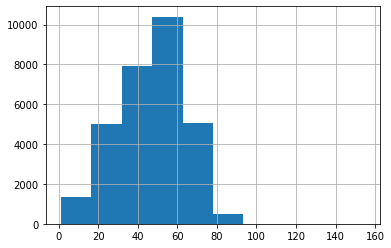

In [20]:
patientInfo['patientAge'].hist()

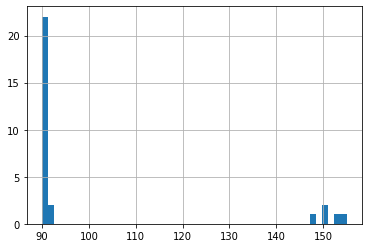

In [21]:
patientInfo[patientInfo['patientAge']>=90]['patientAge'].hist(bins=50)

In [22]:
patientInfo[patientInfo['patientAge']>=85]['patientAge'].value_counts()

86     25
87     20
90     19
85     16
88     12
89      8
91      3
92      2
155     1
153     1
151     1
150     1
148     1
Name: patientAge, dtype: int64

In [23]:
#exploring gender

patientInfo['patientSex'].unique()


array(['F', 'M'], dtype=object)

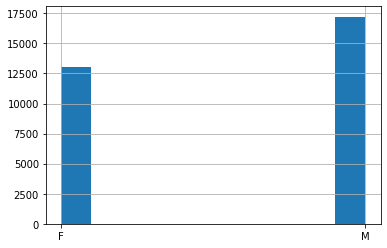

In [24]:
patientInfo['patientSex'].hist()

Exploring Images

In [0]:
def draw_img(patient_id, title=None):
    dcm_file = 'Data/DCM_Train_Images/%s.dcm' % patient_id
    dcm_data = pydicom.read_file(dcm_file)
    plt.imshow(dcm_data.pixel_array)
    if title is not None:
        plt.title(title)

In [0]:
patients_greater_100 = patientInfo[patientInfo['patientAge']>=100]
patients_less_5 = patientInfo[patientInfo['patientAge']<=5]
patients_mid_age = patientInfo[(patientInfo['patientAge']>=30) & (patientInfo['patientAge']<= 50)]

In [0]:
def draw_grid(arr_patients, rows=5, columns=4, titles=None, figsize=(15, 15)):
    fig=plt.figure(figsize=figsize)
    for i in range(1, columns*rows + 1):
        if(i <= len(arr_patients)):
            fig.add_subplot(rows, columns, i)
            if titles is None:
                    draw_img(arr_patients[i - 1])
            else:
                    draw_img(arr_patients[i - 1], title=titles[i - 1])
    plt.show()

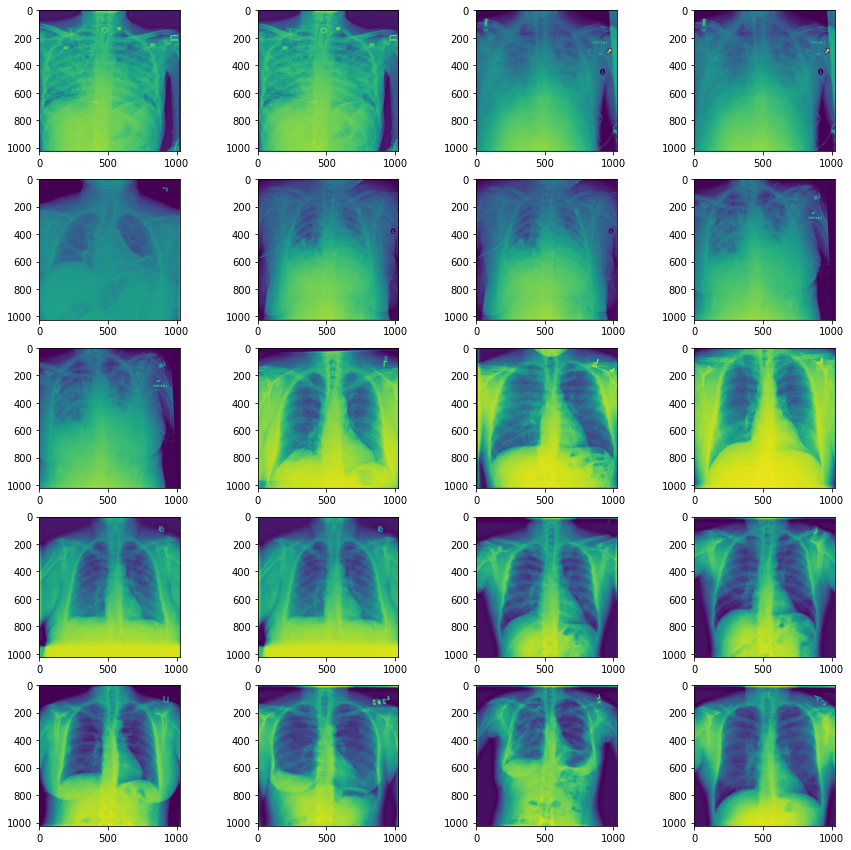

In [33]:
draw_grid(patients_mid_age['patientId'].tolist())

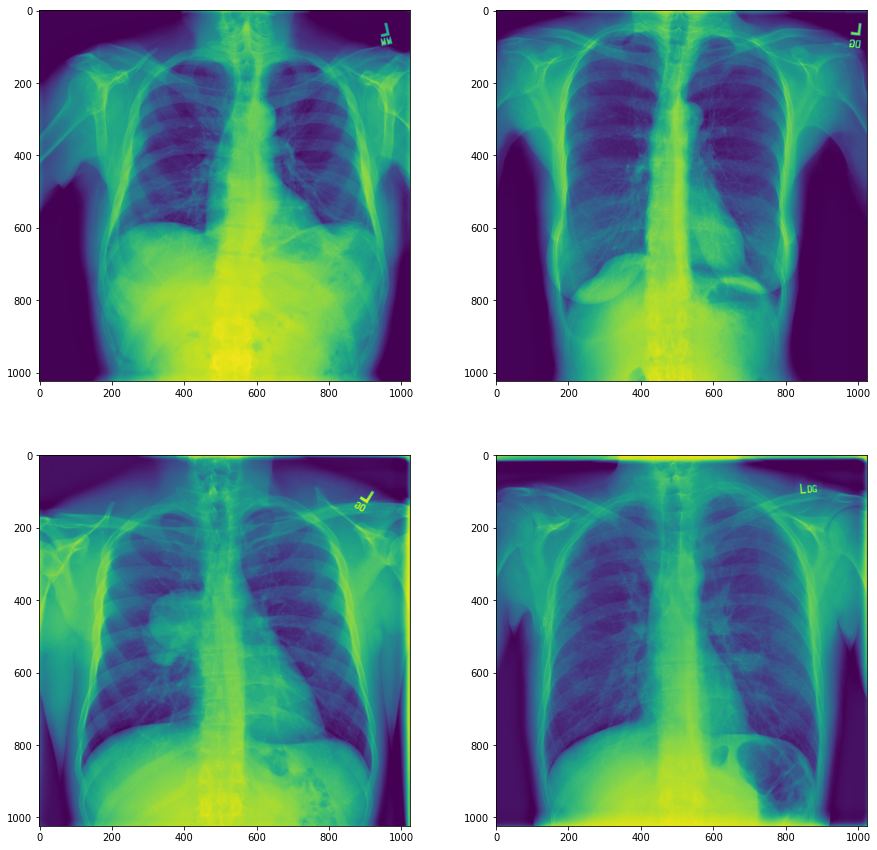

In [34]:
draw_grid(patients_greater_100['patientId'].tolist(), 2, 2)

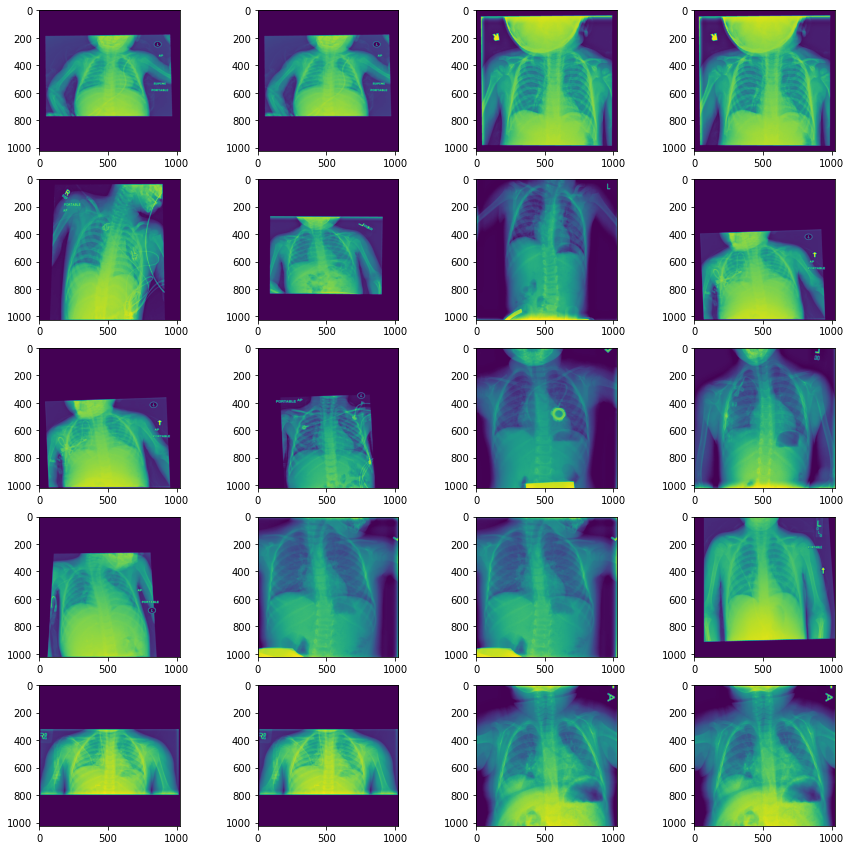

In [35]:
draw_grid(patients_less_5['patientId'].tolist())

In [0]:
patientInfo['age_category'] = (patientInfo['patientAge'] // 10) * 10

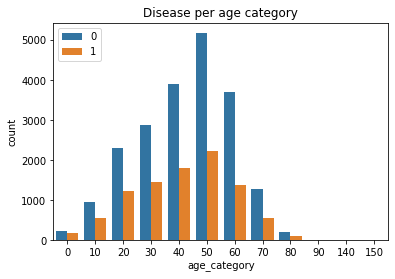

In [37]:
ax = sns.countplot(x="age_category", hue="Target", data=patientInfo)
ax.set_title('Disease per age category')
ax.legend(title='Disease')
ax.legend()

We can explore now further the Gender attribute

In [38]:
#display the count of each gender
patientInfo['patientSex'].value_counts()

M    17216
F    13011
Name: patientSex, dtype: int64

Radiation images of male vs female

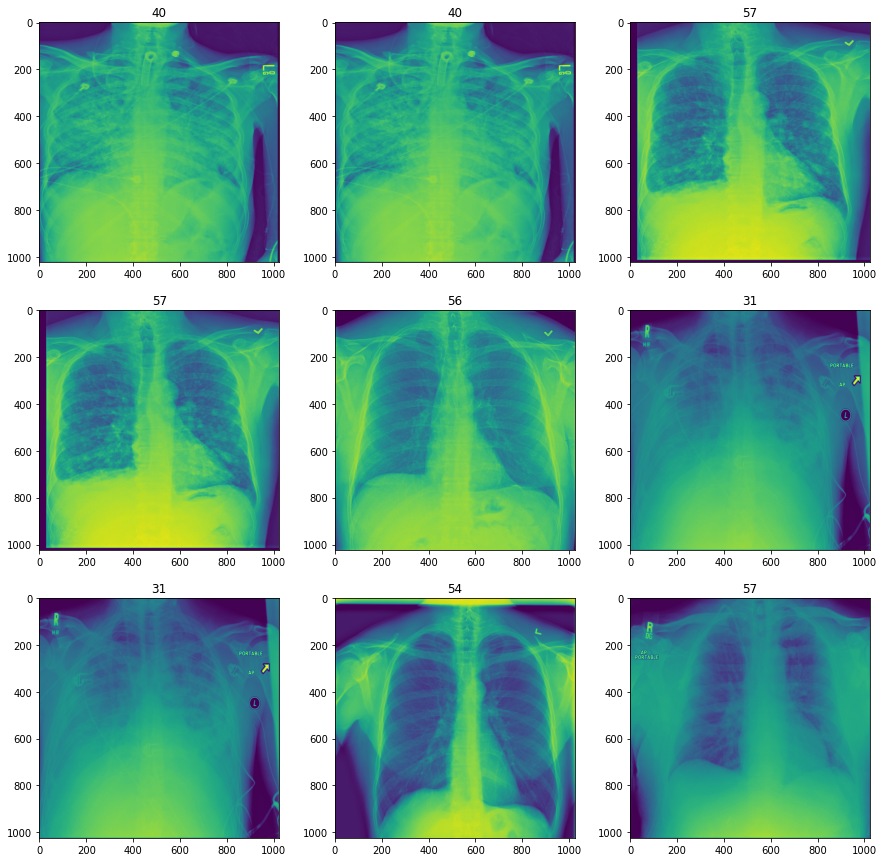

In [40]:
draw_grid(patientInfo[patientInfo['patientSex'] == 'M']['patientId'].tolist(), 3, 3, 
          titles=patientInfo[patientInfo['patientSex'] == 'M']['patientAge'].tolist(), figsize=(15, 15))



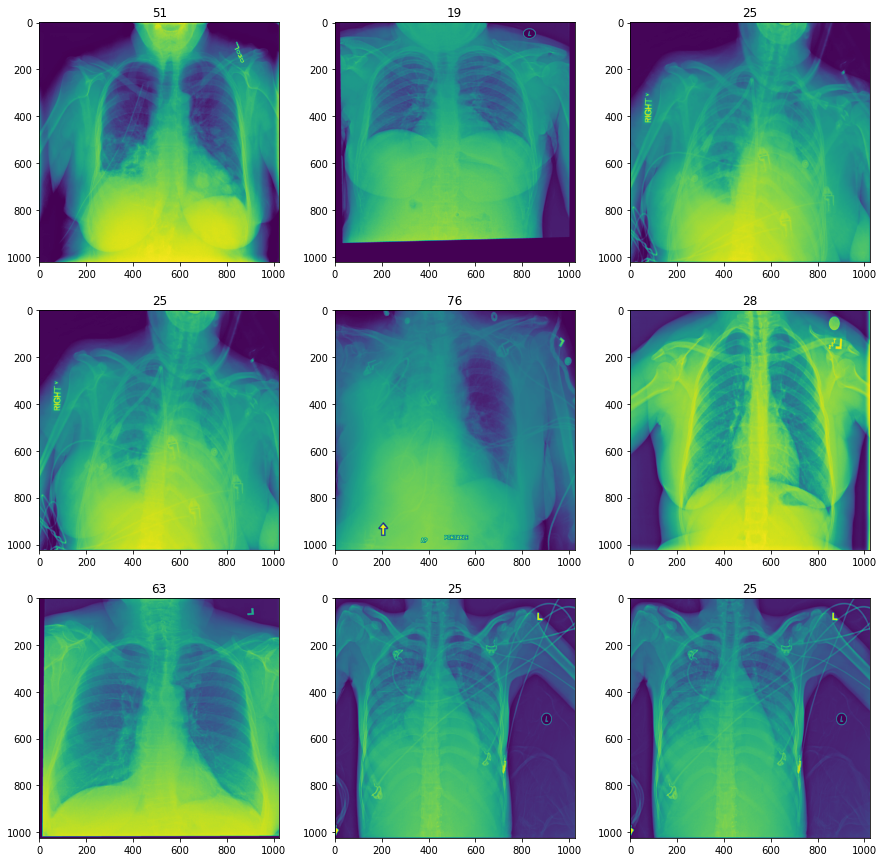

In [41]:
draw_grid(patientInfo[patientInfo['patientSex'] == 'F']['patientId'].tolist(), 3, 3, 
          titles=patientInfo[patientInfo['patientSex'] == 'F']['patientAge'].tolist(), figsize=(15, 15))

There is not visible difference in the images on the basis of gender

We can now visualise the disease in each gender

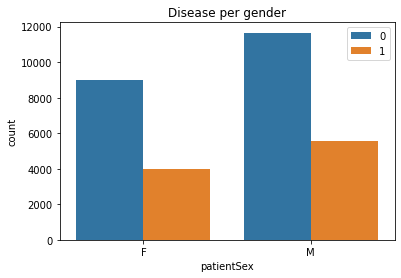

In [42]:
ax = sns.countplot(x="patientSex", hue="Target", data=patientInfo)
ax.set_title('Disease per gender')
ax.legend(title='Disease')
ax.legend()